In [ ]:
!pip install gcsfs pyarrow

In [ ]:
pip install sentence-transformers


In [ ]:
!pip install faiss-cpu


In [ ]:
pip install transformers accelerate bitsandbytes


In [ ]:
!pip install llama-cpp-python

In [ ]:
!pip install -q transformers


In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np

import faiss
import numpy as np

import matplotlib.pyplot as plt

from sentence_transformers import util

from sklearn.metrics.pairwise import cosine_distances
import numpy as np

from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
import pandas as pd

gcs_path = 'gs://genrec-data-store/Processed_Files/p_processed_all_user_reviews.parquet'

## 1: Group Reviews by ASIN
Goal: Combine all reviews written for the same product (i.e., same asin) into one long text per item.

In [ ]:
# Step 1: Load the preprocessed reviews file
df = pd.read_parquet(gcs_path, engine='pyarrow')

In [ ]:
df.tail(10)

,reviewerID,asin,rating,reviewText,category
46850837,A97SFUJ82RSGA,B017N39T58,5,i thought it wouldn ##t work because it was ch...,Electronics
46850838,A97SFUJ82RSGA,B017N39T58,5,i got this mac ##book screen cover for work pe...,Electronics
46850839,A97SFUJ82RSGA,B017N39T58,5,i bought this product for my son we love it no...,Electronics
46850840,A7NS5NFV55Q8F,B01AXZ4C28,5,use it with my mac ##book pro works well,Electronics
46850841,A7NS5NFV55Q8F,B01B9OO1CS,5,the keyboard works well hasn ##t la ##gged or ...,Electronics
46850842,A7NS5NFV55Q8F,B01DOB6Y6A,1,bought this thinking that it would last longer...,Electronics
46850843,A7NS5NFV55Q8F,B01DTMA0FK,5,great product and cheaper than black rapid,Electronics
46850844,A7NS5NFV55Q8F,B01FFDA5AQ,5,great case and protected it as we traveled to ...,Electronics
46850845,A7NS5NFV55Q8F,B01FWXZE1E,4,it covers well i think there ##s a little open...,Electronics
46850846,A7NS5NFV55Q8F,B01HCGZ482,5,solid product for ipad,Electronics


In [ ]:
# Step 2: Group all reviews for each product (asin)
grouped_reviews = df.groupby("asin")["reviewText"].apply(lambda x: " ".join(x)).reset_index()

In [ ]:
# Step 3: Rename columns for clarity
grouped_reviews.columns = ["asin", "text"]

In [ ]:
grouped_reviews.to_parquet("grouped_reviews.parquet", index=False)

In [ ]:
from google.colab import files
files.download('grouped_reviews.parquet')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 2 - Generate Embeddings for Each Item
Goal: Convert each item’s text (combined reviews) into a dense vector using a sentence embedding model. These embeddings let us compare items based on the meaning of their reviews — enabling semantic search.



Tools:
We’ll use the sentence-transformers library with the model all-mpnet-base-v2, which is fast, strong semantic quality and widely used for retrieval tasks.





i/p: The grouped_reviews DataFrame from Step 1.

o/p: A NumPy array embeddings where, embeddings[i] is the semantic vector for the item at grouped_reviews.iloc[i].

In [ ]:
# Step 1: Load the pretrained sentence transformer model
model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")
model = model.to("cuda")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
print(grouped_reviews.shape)


(1567844, 2)


In [ ]:
# Step 2: Convert texts to embeddings (in batches for efficiency)
texts = grouped_reviews["text"].tolist()

embeddings = model.encode(
    texts,
    batch_size=512,
    show_progress_bar=True,
    normalize_embeddings=True,      # Recommended for cosine similarity with FAISS
    device="cuda"                   # Ensures GPU is used
)
# embeddings will be a numpy array of shape (num_items, embedding_dim)
# e.g., (1 million items, 768 dimensions)

Batches:   0%|          | 0/3063 [00:00<?, ?it/s]

## 3- Build and Store the FAISS Index
Goal:
Create a fast vector search index using FAISS so you can quickly retrieve the Top-K similar items for any query.
Tools:
We’ll use FAISS for approximate nearest neighbor (ANN) search.

Since you're using normalized embeddings (normalize_embeddings=True), we will use inner product (cosine similarity).

In [ ]:
# Normalize the embeddings again (just in case)
faiss.normalize_L2(embeddings)

In [ ]:
# Create FAISS index with cosine similarity
index = faiss.IndexFlatIP(embeddings.shape[1])  # 768-dim
index.add(embeddings)

In [ ]:
# Save index to disk
faiss.write_index(index, "faiss_item_index.index")


In [ ]:
# Save the ASINs in the same order as the index
asin_list = grouped_reviews["asin"].tolist()
pd.Series(asin_list).to_csv("asin_mapping.csv", index=False)

## 4- Retrieval in Action
Goal: Given a user query or user history, retrieve the Top-K most similar items from the FAISS index using semantic search.

What You Have Now:
1. faiss_item_index.index → FAISS vector index

2. asin_mapping.csv → item ID list, row-by-row aligned to the FAISS index

3. model → your SentenceTransformer model

4. Normalized embeddings (normalize_embeddings=True)

In [ ]:
asin_df = pd.read_csv("asin_mapping.csv")
print(asin_df.columns)

Index(['0'], dtype='object')


In [ ]:
pd.Series(asin_list, name="asin").to_csv("asin_mapping.csv", index=False)


In [ ]:
# Step 1: Load the FAISS Index and ASIN Mapping
index = faiss.read_index("faiss_item_index.index")
asin_list = pd.read_csv("asin_mapping.csv")["asin"].tolist()

In [ ]:
'''
This function retrieves the Top-K relevant items for a user query using FAISS,
then removes duplicate-like items by filtering out those with overly similar review text.

It also assigns a diversity score to each remaining item based on how semantically different
it is from the others, and ranks them to ensure the final set is both relevant and diverse.
'''

def retrieve_diverse_items(query_text, model, index, asin_list, df, top_k=10):
    import numpy as np
    from sentence_transformers import util
    from sklearn.metrics.pairwise import cosine_distances

    # Step 1: Encode the query and retrieve top_k ASINs
    query_vector = model.encode([query_text], normalize_embeddings=True, device="cuda")
    D, I = index.search(query_vector, top_k)
    retrieved_asins = [asin_list[i] for i in I[0]]

    # Step 2: Get original review texts
    results = df[df["asin"].isin(retrieved_asins)]

    # Step 3: Aggregate review texts by ASIN
    dedup_df = results.groupby("asin")["reviewText"].apply(lambda x: " ".join(x)).reset_index()

    # Step 4: Encode item texts
    dedup_embeddings = model.encode(
        dedup_df["reviewText"].tolist(),
        batch_size=64,
        normalize_embeddings=True,
        device="cuda"
    )

    # Step 5: Deduplicate based on similarity > 0.95
    cos_sim_matrix = util.pytorch_cos_sim(dedup_embeddings, dedup_embeddings)

    keep_indices = []
    seen = set()
    for i in range(len(dedup_df)):
        if i in seen:
            continue
        keep_indices.append(i)
        similar_items = (cos_sim_matrix[i] > 0.95).nonzero(as_tuple=True)[0].tolist()
        seen.update(similar_items)

    diverse_df = dedup_df.iloc[keep_indices].reset_index(drop=True)

    # Step 6: Diversity scoring using pairwise cosine distance
    diversity_matrix = cosine_distances(dedup_embeddings[keep_indices])
    diversity_scores = np.mean(diversity_matrix, axis=1)
    diverse_df["diversity_score"] = diversity_scores

    # Step 7: Rank by diversity score
    diverse_df = diverse_df.sort_values("diversity_score", ascending=False).reset_index(drop=True)

    return diverse_df


In [ ]:
#Step 2: Define a Sample User Query
# Example user history or query
query_text = "looking for a durable lightweight ipad case"

In [ ]:
# Step 3: Retrieve Diverse Items for the Query

diverse_df = retrieve_diverse_items(
    query_text=query_text,
    model=model,
    index=index,
    asin_list=asin_list,
    df=df,             # Your full review dataset
    top_k=20           # You can change this to 10/50 as needed
)

In [ ]:
diverse_df.head(10)

,asin,reviewText,diversity_score
0,B002N8726W,while i have a case for my ipad i wanted a sat...,0.311574
1,B005FNKMIC,would prefer that it was leather but of course...,0.275273
2,B00JGHVKPC,its rare to find an ipad case that protects yo...,0.266474
3,B00Y1PM3XC,got this for my ipad mini best case i have eve...,0.249326
4,B004R6CLUK,i wanted a case that was thin yet strong fit w...,0.247355
5,B00JG8LN9Y,the shock ##wave for ipad air is by far the be...,0.245939
6,B0050JRYL4,i wanted something that was extremely thin so ...,0.237442
7,B00G3NDFW8,excellent case for ipad air i am using from al...,0.236583
8,B007FPISNE,i like the bel ##kin cinema dot f ##olio with ...,0.235462
9,B00MJX9CFU,if you are looking for a very rugged case for ...,0.233675


In [ ]:
# Summarize or Rank the Retrieved Items
ranked = results.groupby("asin").agg({
    "rating": "mean",
    "reviewText": lambda x: " ".join(x)
}).sort_values("rating", ascending=False)


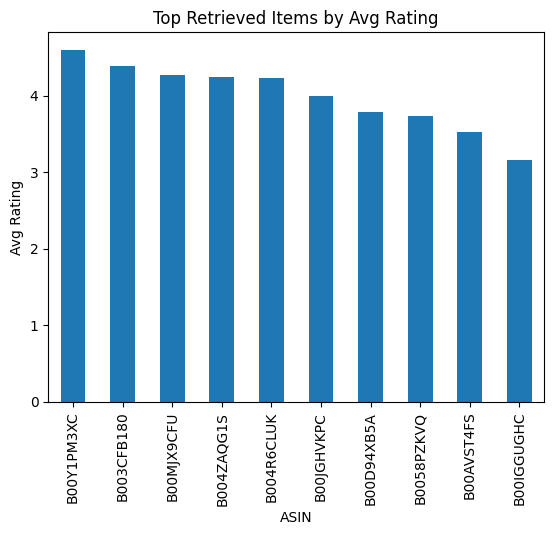

In [ ]:
# Visualize Retrieval Results
results.groupby("asin")["rating"].mean().sort_values(ascending=False).head(10).plot(kind='bar')
plt.title("Top Retrieved Items by Avg Rating")
plt.xlabel("ASIN")
plt.ylabel("Avg Rating")
plt.show()

Remove Near-Duplicates Based on Review Text Similarity

In [ ]:
# Step 1: Combine review texts per ASIN (if not already)
dedup_df = results.groupby("asin")["reviewText"].apply(lambda x: " ".join(x)).reset_index()

In [ ]:
# Step 2: Encode the review texts of retrieved items
dedup_embeddings = model.encode(
    dedup_df["reviewText"].tolist(),
    batch_size=64,
    show_progress_bar=True,
    normalize_embeddings=True,
    device="cuda"
)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# Step 3: Compute cosine similarity matrix
cos_sim_matrix = util.pytorch_cos_sim(dedup_embeddings, dedup_embeddings)

In [ ]:
# Step 4: Keep only diverse ASINs (remove those > 0.95 similarity)
import numpy as np

keep_indices = []
seen = set()

for i in range(len(dedup_df)):
    if i in seen:
        continue
    keep_indices.append(i)
    similar_items = (cos_sim_matrix[i] > 0.95).nonzero(as_tuple=True)[0].tolist()
    seen.update(similar_items)


In [ ]:
# Step 5: Filter to keep only diverse items
diverse_df = dedup_df.iloc[keep_indices].reset_index(drop=True)
print(f"Kept {len(diverse_df)} diverse items out of {len(dedup_df)} retrieved.")

Kept 10 diverse items out of 10 retrieved.


Diversity Score Code

In [ ]:
# You already have this from dedup step
# dedup_embeddings -> embeddings of diverse_df["reviewText"]

# Step 1: Compute cosine distance matrix (not similarity)
diversity_matrix = cosine_distances(dedup_embeddings)

# Step 2: For each item, compute average distance to others
diversity_scores = np.mean(diversity_matrix, axis=1)

# Step 3: Add score to DataFrame
diverse_df["diversity_score"] = diversity_scores

# Step 4: Rank items by diversity
diverse_df = diverse_df.sort_values("diversity_score", ascending=False)

## 5 -

In [ ]:
# from mistral_common.tokens.tokenizers.mistral import MistralTokenizer
# from mistral_common.protocol.instruct.messages import UserMessage
# from mistral_common.protocol.instruct.request import ChatCompletionRequest

# mistral_models_path = "MISTRAL_MODELS_PATH"

# tokenizer = MistralTokenizer.v1()

# completion_request = ChatCompletionRequest(messages=[UserMessage(content="Explain Machine Learning to me in a nutshell.")])

# tokens = tokenizer.encode_chat_completion(completion_request).tokens


In [ ]:
from transformers import pipeline

# Load the model pipeline
pipe = pipeline("text-generation", model="openchat/openchat-3.5-0106", device=0)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/651 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/179 [00:00<?, ?B/s]

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/491 [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
# Step 5a: Query Understanding
query = "Show me best phones"
clarified = pipe(f"Rewrite this search query to be more specific: '{query}'", max_new_tokens=100)[0]['generated_text']
print("Clarified Query:\n", clarified)

Clarified Query:
 Rewrite this search query to be more specific: 'Show me best phones'

- 'What are the best phones'
- 'Which phones are the best'
- 'What are the best phones in 2021'
- 'Top 10 best phones 2021'
- 'Best phones under 300'
- 'Best Android phones'
- 'Best iPhone phones'
- 'Best mid-range phones'
- 'Best budget phones'
- 'Best camera phones'
- '


In [ ]:
# Step 5b: Generative Diversity Enhancement
diverse_versions = pipe(f"Give 3 diverse versions of this search query: '{query}'", max_new_tokens=100)[0]['generated_text']
print("\n🎨 Diverse Queries:\n", diverse_versions)



🎨 Diverse Queries:
 Give 3 diverse versions of this search query: 'Show me best phones'

1. "Show me the top 5 best phones available in the market right now."
2. "Give me a list of the top 10 best phones that are currently on sale."
3. "Recommend the top 3 best smartphones that offer the best value for money."

In each case, the searcher is looking for the same information: the best phones available. However, each query is phrased differently, emphasizing different aspects of


In [ ]:
# Step 5c: Feedback Explanation
explanation = pipe(f"Why would a user ask: '{query}'? Give a short rationale.", max_new_tokens=80)[0]['generated_text']
print("\n💬 Explanation of Intent:\n", explanation)


💬 Explanation of Intent:
 Why would a user ask: 'Show me best phones'? Give a short rationale.

A user might ask 'Show me best phones' because they are interested in purchasing a new phone, and they want to see a list of the top options available in the market, based on various criteria such as performance, battery life, camera quality, and price.
